In [343]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

file_path = "./Dummy_02.csv"

In [344]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else 'cpu')
print(f'다음 기기로 학습 : {device}')

다음 기기로 학습 : cuda


In [345]:
# 1. 데이터 로드
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

In [346]:
# 2. 시간 데이터 처리
def process_time_data(df):
    # event_time을 datetime 형식으로 변환
    df['event_time'] = pd.to_datetime(df['event_time'])
    
    # 날짜 정보(연, 월, 일) 추출
    df['year'] = df['event_time'].dt.year
    df['month'] = df['event_time'].dt.month
    df['day'] = df['event_time'].dt.day

    # epc_code별 event_time 차이 계산 (초 단위)
    df['time_diff'] = df.groupby('epc_code')['event_time'].diff().dt.total_seconds().fillna(0)
    
    # time_diff 값을 로그 변환하여 스케일 조정
    df['time_diff'] = np.log1p(df['time_diff'])
    
    # time_diff의 다양한 단위 변환 추가
    df['time_diff_minutes'] = df['time_diff'] / 60
    df['time_diff_hours'] = df['time_diff'] / 3600
    df['time_diff_days'] = df['time_diff'] / 86400

    # 시간(hour)의 주기적 특성 인코딩
    df['hour'] = df['event_time'].dt.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # 월(month)의 주기적 특성 인코딩
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # 일(day)의 주기적 특성 인코딩
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    # 불필요한 원본 값 삭제
    df = df.drop(columns=['event_time', 'year', 'month', 'day', 'hour'], errors='ignore')
    return df

In [347]:
# 3. 인코딩
def encode_categorical_data(df):
    # hub_type, event_type 라벨 인코딩
    le_hub = LabelEncoder()
    le_event = LabelEncoder()
    df['hub_type_encoded'] = le_hub.fit_transform(df['hub_type'])
    df['event_type_encoded'] = le_event.fit_transform(df['event_type'])

    # 허브 및 이벤트의 이전 상태 추가 (순서 학습 강화)
    df['hub_type_shifted'] = df.groupby('epc_code')['hub_type_encoded'].shift(1).fillna(-1)
    df['event_type_shifted'] = df.groupby('epc_code')['event_type_encoded'].shift(1).fillna(-1)

    # 허브 이동 횟수 추가 (허브 변경 감지)
    df['hub_transition'] = (df['hub_type_encoded'] != df['hub_type_encoded'].shift(1)).astype(int)
    
    # 원본 hub_type과 event_type 삭제 (인코딩 후 불필요)
    df = df.drop(columns=['hub_type', 'event_type', 'product_serial', 'product_name'], errors='ignore')
    
    return df

In [348]:
# 4. 시계열 데이터 구성
def create_sequences(df, seq_length):
    sequences = []
    for _, group in df.groupby('epc_code'):
        group_data = group[["time_diff_minutes", "hub_transition", "event_type_shifted", "hub_type_encoded", "event_type_encoded", "hour_sin", "month_sin"]].values
        for i in range(0, len(group_data) - seq_length + 1, seq_length):
            sequences.append(group_data[i:i + seq_length])
    return np.array(sequences)


In [349]:
# 데이터 로드
df = load_data(file_path)

# 시간 데이터 처리
df = process_time_data(df)

# 카테고리형 데이터 인코딩
df = encode_categorical_data(df)

# 변환된 데이터 확인
display(df.head(10))

,epc_code,time_diff,time_diff_minutes,time_diff_hours,time_diff_days,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,hub_type_encoded,event_type_encoded,hub_type_shifted,event_type_shifted,hub_transition
0,001.8805843.584374.000000001,0.000000,0.000000,0.000000,0.000000,-9.659258e-01,-2.588190e-01,0.500000,8.660254e-01,-0.897805,-0.440394,5,3,-1.0,-1.0,1
1,001.8805843.584374.000000001,7.139660,0.118994,0.001983,0.000083,-1.000000e+00,-1.836970e-16,0.500000,8.660254e-01,-0.897805,-0.440394,5,2,5.0,3.0,0
2,001.8805843.584374.000000001,7.783641,0.129727,0.002162,0.000090,-1.000000e+00,-1.836970e-16,0.500000,8.660254e-01,-0.897805,-0.440394,5,0,5.0,2.0,0
3,001.8805843.584374.000000001,12.627414,0.210457,0.003508,0.000146,9.659258e-01,-2.588190e-01,0.500000,8.660254e-01,-0.937752,0.347305,5,1,5.0,0.0,0
4,001.8805843.584374.000000001,9.372544,0.156209,0.002603,0.000108,5.000000e-01,-8.660254e-01,0.500000,8.660254e-01,-0.937752,0.347305,0,4,5.0,1.0,1
5,001.8805843.584374.000000001,14.942594,0.249043,0.004151,0.000173,8.660254e-01,5.000000e-01,1.000000,6.123234e-17,0.394356,0.918958,0,7,0.0,4.0,0
6,001.8805843.584374.000000001,10.280587,0.171343,0.002856,0.000119,1.224647e-16,-1.000000e+00,1.000000,6.123234e-17,0.394356,0.918958,0,6,0.0,7.0,0
7,001.8805843.584374.000000001,14.610176,0.243503,0.004058,0.000169,7.071068e-01,7.071068e-01,1.000000,6.123234e-17,-0.571268,0.820763,0,9,0.0,6.0,0
8,001.8805843.584374.000000001,9.643485,0.160725,0.002679,0.000112,9.659258e-01,-2.588190e-01,1.000000,6.123234e-17,-0.571268,0.820763,0,5,0.0,9.0,0
9,001.8805843.584374.000000001,14.376680,0.239611,0.003994,0.000166,-5.000000e-01,-8.660254e-01,0.866025,-5.000000e-01,-0.299363,-0.954139,0,8,0.0,5.0,0


In [350]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 상관관계 히트맵
# correlation_matrix = df.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
# plt.title("Feature Correlation Matrix")
# plt.show()

In [351]:
# 5. 데이터 정규화
def normalize_data(sequences):
    minmax_scaler = MinMaxScaler()
    minmax_indices = [0]  # time_diff 관련 열

    standard_scaler = StandardScaler()
    standard_indices = [5, 6]  # 시간 주기적 변수

    # MinMaxScaler 적용
    sequences[:, :, minmax_indices] = minmax_scaler.fit_transform(
        sequences[:, :, minmax_indices].reshape(-1, len(minmax_indices))
    ).reshape(sequences.shape[0], sequences.shape[1], len(minmax_indices))

    # StandardScaler 적용
    sequences[:, :, standard_indices] = standard_scaler.fit_transform(
        sequences[:, :, standard_indices].reshape(-1, len(standard_indices))
    ).reshape(sequences.shape[0], sequences.shape[1], len(standard_indices))

    return sequences

In [352]:
 # 6. 데이터 분할
def split_data(sequences, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    X_train, X_temp = train_test_split(sequences, test_size=val_ratio + test_ratio, random_state=42)
    X_val, X_test = train_test_split(X_temp, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)
    return X_train, X_val, X_test

In [353]:
# 7. Autoencoder 모델 생성
def build_autoencoder(seq_length, feature_dim):
    input_seq = layers.Input(shape=(seq_length, feature_dim))
    x = layers.LSTM(256, activation='relu', return_sequences=True)(input_seq)
    x = layers.LSTM(128, activation='relu', return_sequences=True)(x)
    x = layers.LSTM(64, activation='relu', return_sequences=False)(x)
    latent = layers.Dense(32, activation='relu')(x)
    x = layers.RepeatVector(seq_length)(latent)
    x = layers.LSTM(64, activation='relu', return_sequences=True)(x)
    x = layers.LSTM(128, activation='relu', return_sequences=True)(x)
    x = layers.LSTM(256, activation='relu', return_sequences=True)(x)
    output_seq = layers.TimeDistributed(layers.Dense(feature_dim))(x)
    autoencoder = models.Model(input_seq, output_seq)
    return autoencoder

In [354]:
# 8. 파이프라인 실행
def preprocess_pipeline(file_path, seq_length=10):
    df = load_data(file_path)
    df = process_time_data(df)
    df = encode_categorical_data(df)
    sequences = create_sequences(df, seq_length)
    sequences = normalize_data(sequences)
    X_train, X_val, X_test = split_data(sequences)
    return X_train, X_val, X_test

In [355]:
# 9. 재구성 결과 시각화
def visualize_reconstruction(X_test, reconstructed, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 10))
    for i in range(n_samples):
        axes[i, 0].plot(np.mean(X_test[i], axis=1), label="Original", alpha=0.7)
        axes[i, 0].set_title(f"Original Sequence {i+1}")
        axes[i, 0].legend()
        axes[i, 1].plot(np.mean(reconstructed[i], axis=1), label="Reconstructed", alpha=0.7, linestyle="--")
        axes[i, 1].set_title(f"Reconstructed Sequence {i+1}")
        axes[i, 1].legend()
    plt.tight_layout()
    plt.show()

In [356]:
# 10. 재구성 오류 분포 시각화
def plot_reconstruction_error(X_test, reconstructed):
    errors = np.mean(np.abs(X_test - reconstructed), axis=(1, 2)) #mse -> abs로 교체 후 성능 개선
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, alpha=0.75, color='blue', label='Reconstruction Error')
    plt.axvline(np.mean(errors) + 2 * np.std(errors), color='red', linestyle='--', label='Threshold (Mean + 3*Std)')
    plt.title("Reconstruction Error Distribution")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    return errors

In [357]:
# 11. 이상치 탐지 및 시각화
def detect_anomalies(errors, threshold):
    total_samples = len(errors)
    anomalies = errors > threshold
    anomaly_count = np.sum(anomalies)
    anomaly_ratio = anomaly_count / total_samples * 100
    print(f"Anomaly ratio: {anomaly_ratio:.2f}%")
    print(f"Number of anomalies detected: {np.sum(anomalies)}")
    return anomalies

def visualize_anomalies(X_test, reconstructed, anomalies, n_samples=5):
    # Ensure data is numpy arrays
    X_test = np.array(X_test)
    reconstructed = np.array(reconstructed)
    
    anomaly_indices = np.where(anomalies)[0]
    
    if len(anomaly_indices) == 0:
        print("No anomalies detected.")
        return
    
    # Ensure anomaly indices do not exceed available samples
    n_samples = min(n_samples, len(anomaly_indices))
    selected_indices = anomaly_indices[:n_samples]
    
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 10))
    for i, idx in enumerate(selected_indices):
        axes[i, 0].plot(np.mean(X_test[idx], axis=1), label="Original", alpha=0.7)
        axes[i, 0].set_title(f"Anomalous Sequence {idx+1}: Original")
        axes[i, 0].legend()
        
        axes[i, 1].plot(np.mean(reconstructed[idx], axis=1), label="Reconstructed", alpha=0.7, linestyle="--")
        axes[i, 1].set_title(f"Anomalous Sequence {idx+1}: Reconstructed")
        axes[i, 1].legend()
    
    plt.tight_layout()
    plt.show()

Epoch 1/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.6903 - loss: 2.4400 - val_accuracy: 0.9789 - val_loss: 0.1342
Epoch 2/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9850 - loss: 0.1322 - val_accuracy: 0.9993 - val_loss: 0.1214
Epoch 3/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9870 - loss: 0.1109 - val_accuracy: 0.9866 - val_loss: 0.0963
Epoch 4/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9862 - loss: 0.1038 - val_accuracy: 0.9795 - val_loss: 0.1018
Epoch 5/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9876 - loss: 0.0785 - val_accuracy: 0.9999 - val_loss: 0.0667
Epoch 6/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9888 - loss: 0.0610 - val_accuracy: 0.9792 - val_loss: 0.0573
Epoch 7/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9882 - loss: 0.0491 - val_accuracy: 0.9849 - val_loss: 0.0443
Epoch 8/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9888 - loss: 0.0479 - val_acc

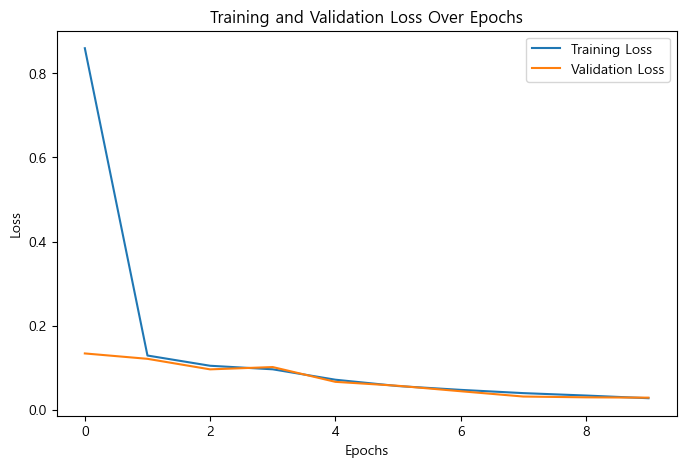

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


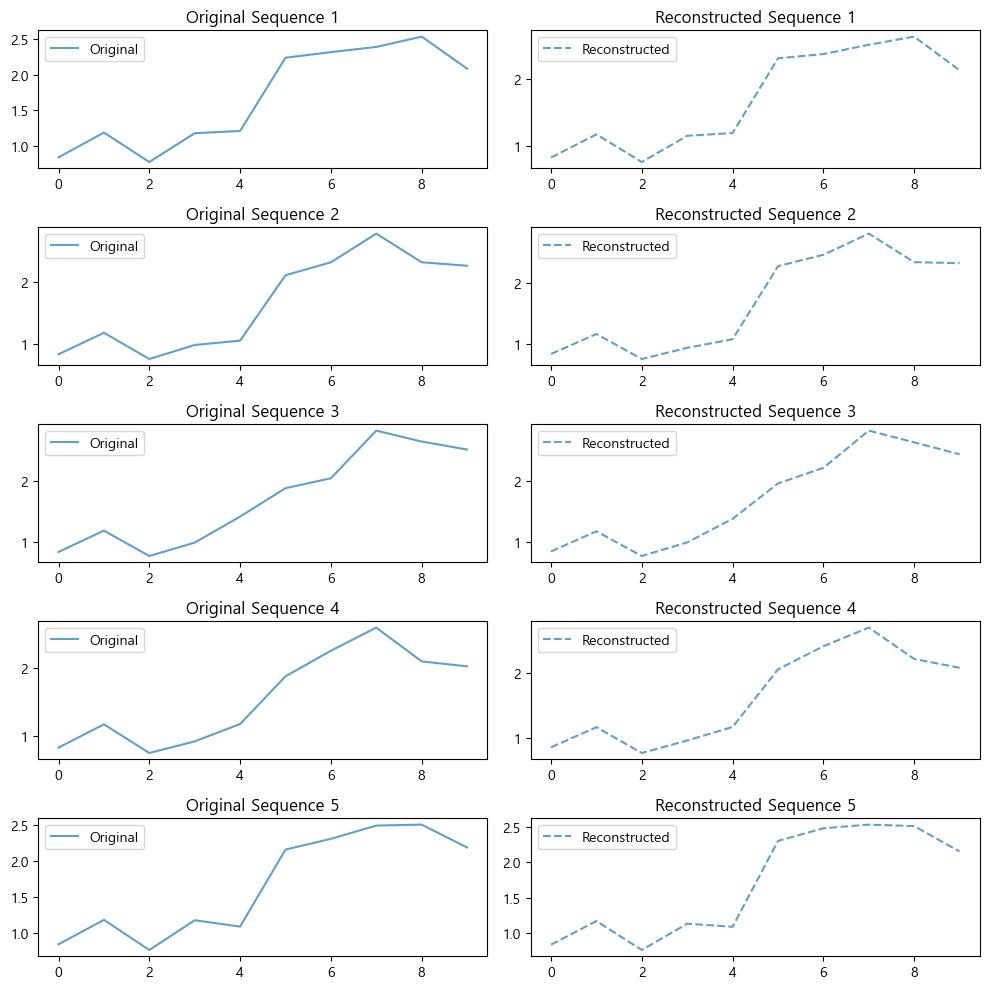

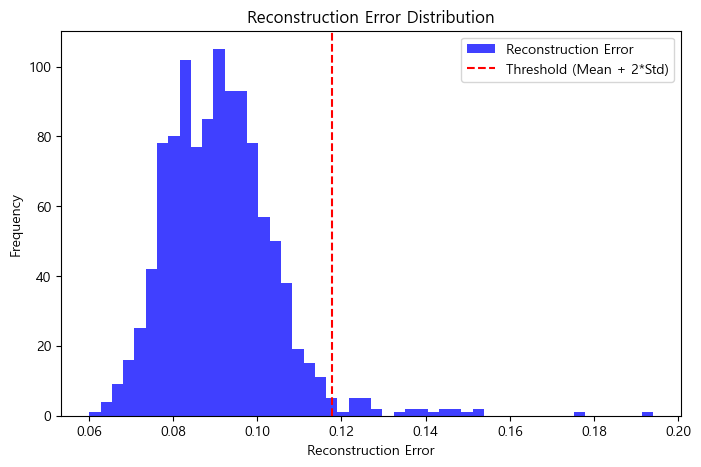

Anomaly ratio: 1.35%
Number of anomalies detected: 15


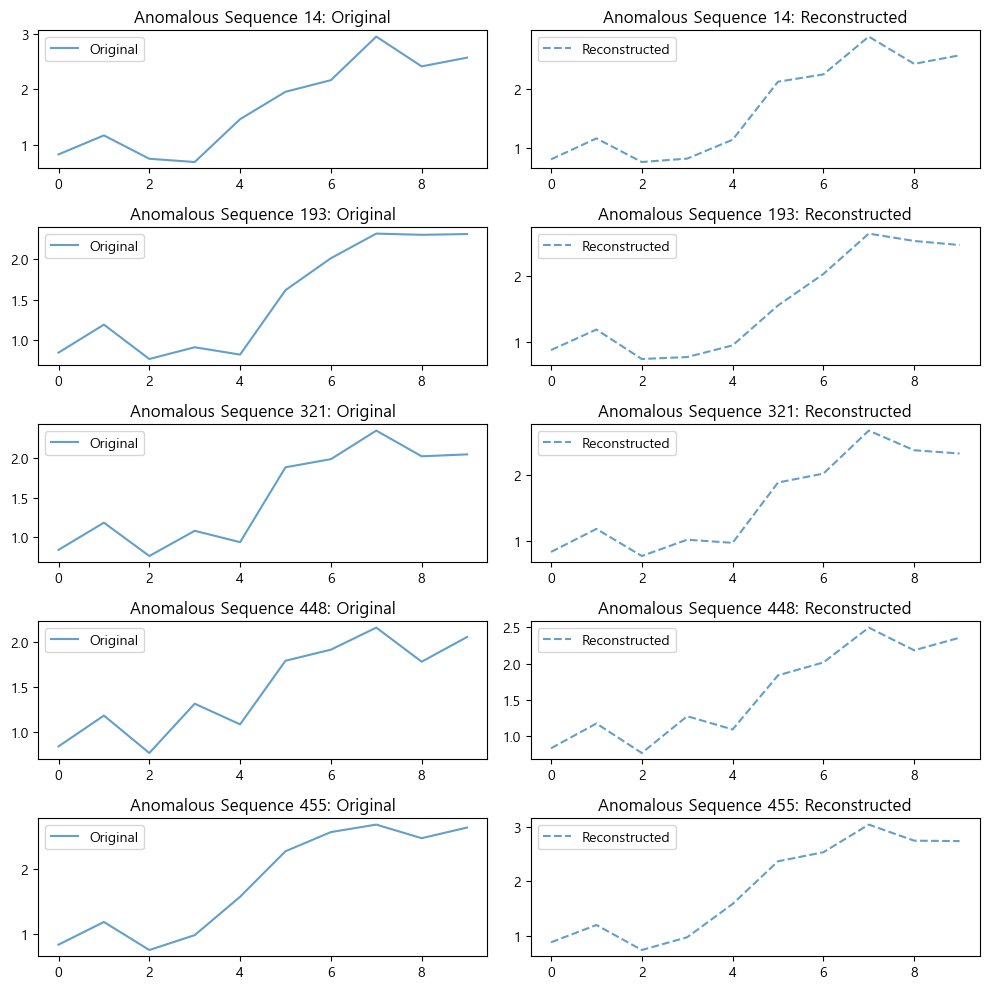

In [358]:
# 12. 실행
seq_length = 10
X_train, X_val, X_test = preprocess_pipeline(file_path, seq_length)

# Autoencoder 생성 및 학습
feature_dim = X_train.shape[2]
autoencoder = build_autoencoder(seq_length, feature_dim)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = autoencoder.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=10, batch_size=32, shuffle=True)

# 학습 과정 시각화 추가
def plot_training_history(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_training_history(history)

# 테스트 데이터 평가 및 결과 분석
reconstructed = autoencoder.predict(X_test)
visualize_reconstruction(X_test, reconstructed)
reconstruction_errors = plot_reconstruction_error(X_test, reconstructed)

# 이상치 탐지
threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
anomalies = detect_anomalies(reconstruction_errors, threshold)
visualize_anomalies(X_test, reconstructed, anomalies)

In [359]:
# 학습 완료 후 모델 저장
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
autoencoder.save('autoencoder_model.h5')